###### Trying to create a model in tensorflow

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import datetime
import os
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import matplotlib.pyplot as plt

In [9]:
# Load dataset
data = pd.read_csv('AmazonDataSales_v2.csv', low_memory=False)
# Drop all columns except 'amount', 'category', 'size', 'quantity'
data = data[['amount', 'category', 'size', 'qty']]

# One-hot encode the 'category', 'size', and 'qty' columns
# Select all columns except 'amount' as feature columns
feature_columns = data.columns.drop('amount')
# One-hot encode the feature columns
data_encoded = pd.get_dummies(data, columns=feature_columns)

# 'df' contains your dataset
X = data_encoded.drop('amount', axis=1)  # Features
y = data['amount']  # Target

In [10]:
# Splitting data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [18]:
X_test.columns

Index(['category_blouse', 'category_bottom', 'category_dupatta',
       'category_ethnic dress', 'category_kurta', 'category_saree',
       'category_set', 'category_top', 'category_western dress', 'size_3xl',
       'size_4xl', 'size_5xl', 'size_6xl', 'size_free', 'size_l', 'size_m',
       'size_s', 'size_xl', 'size_xs', 'size_xxl', 'qty_0', 'qty_1', 'qty_2',
       'qty_3'],
      dtype='object')

In [11]:
# Define the model
input_features = X_train.shape[1]
model = Sequential([
    Dense(2, activation='relu', input_shape=(input_features,)),
    Dense(2, activation='relu'),
    Dense(2, activation='relu'),
    Dense(2, activation='relu'),
    Dense(1)  # Output layer for regression
])

In [12]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [13]:
# EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

In [14]:
# Setup TensorBoard logging
log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [15]:
# Include both TensorBoard and EarlyStopping in the callbacks list
callbacks_list = [tensorboard_callback, early_stopping_callback]

In [16]:
# Train the model with callbacks
history = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    validation_data=(X_val, y_val), 
    callbacks=callbacks_list
)

Epoch 1/100
2205/2205 [==============================] - 6s 2ms/step - loss: 159517.9375 - val_loss: 41124.2969
Epoch 2/100
2205/2205 [==============================] - 5s 2ms/step - loss: 36294.4414 - val_loss: 35847.1484
Epoch 3/100
2205/2205 [==============================] - 5s 2ms/step - loss: 34921.9453 - val_loss: 35489.8047
Epoch 4/100
2205/2205 [==============================] - 5s 2ms/step - loss: 34614.6055 - val_loss: 35233.0156
Epoch 5/100
2205/2205 [==============================] - 5s 2ms/step - loss: 34470.5703 - val_loss: 35220.1094
Epoch 6/100
2205/2205 [==============================] - 5s 2ms/step - loss: 34405.6875 - val_loss: 35153.9375
Epoch 7/100
2205/2205 [==============================] - 5s 2ms/step - loss: 34377.7188 - val_loss: 35089.9492
Epoch 8/100
2205/2205 [==============================] - 5s 2ms/step - loss: 34366.2578 - val_loss: 35048.3789
Epoch 9/100
2205/2205 [==============================] - 5s 2ms/step - loss: 34350.8555 - val_loss: 35046.5977


In [21]:
# Evaluate the test loss and printing it
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}") 

# Generate predictions for use with other things
predictions = model.predict(X_test)

# Calculate R-squared score with scikit-learn and the generated predictions on the test set
r2 = r2_score(y_test, predictions.flatten())  # Ensure y_test and predictions are appropriately shaped
print(f"R-squared value: {r2}")

735/735 [==============================] - 1s 1ms/step - loss: 35550.9453
Test Loss: 35550.9453125
735/735 [==============================] - 1s 1ms/step
R-squared value: 0.42540038392415847


In [27]:
flat_predictions = model.predict(X_test).flatten()  # Flatten to ensure it's a 1D array


735/735 [==============================] - 1s 1ms/step


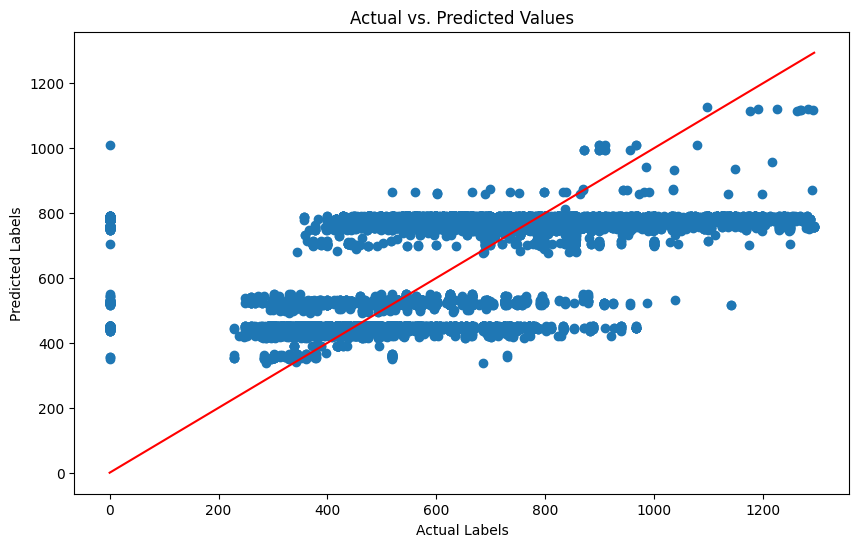

In [28]:
# Scatter plot of Actual vs. Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, flat_predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Actual vs. Predicted Values')

# Plotting the perfect prediction line
max_val = max(max(y_test), max(flat_predictions))
min_val = min(min(y_test), min(flat_predictions))
plt.plot([min_val, max_val], [min_val, max_val], color='red')  # Perfect predictions line
plt.show()

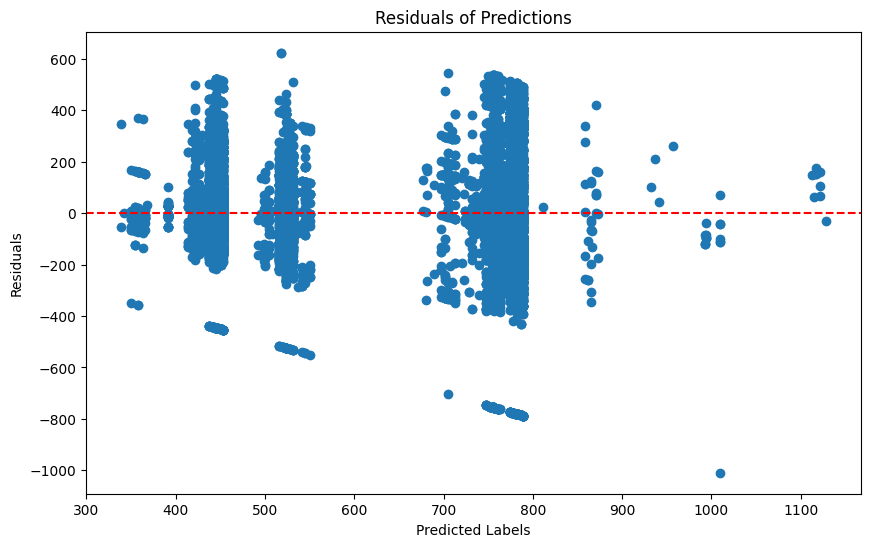

In [29]:
residuals = y_test - flat_predictions

plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals)
plt.xlabel('Predicted Labels')
plt.ylabel('Residuals')
plt.title('Residuals of Predictions')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()


In [37]:
# Convert residuals to a DataFrame, assuming residuals and X_test share the same index
residuals_df = pd.DataFrame({'residuals': residuals}, index=X_test.index)

In [38]:
# Initialize a dictionary to hold the mean residuals for each feature
mean_residuals = {}

for column in X_test.columns:
    # Filter the rows where the feature is present
    feature_present = X_test[column] == 1

    # Calculate the mean residual for these rows
    mean_residuals[column] = residuals_df['residuals'][feature_present].mean()

# Convert the dictionary to a pandas Series for easy plotting
mean_residuals_per_feature = pd.Series(mean_residuals)


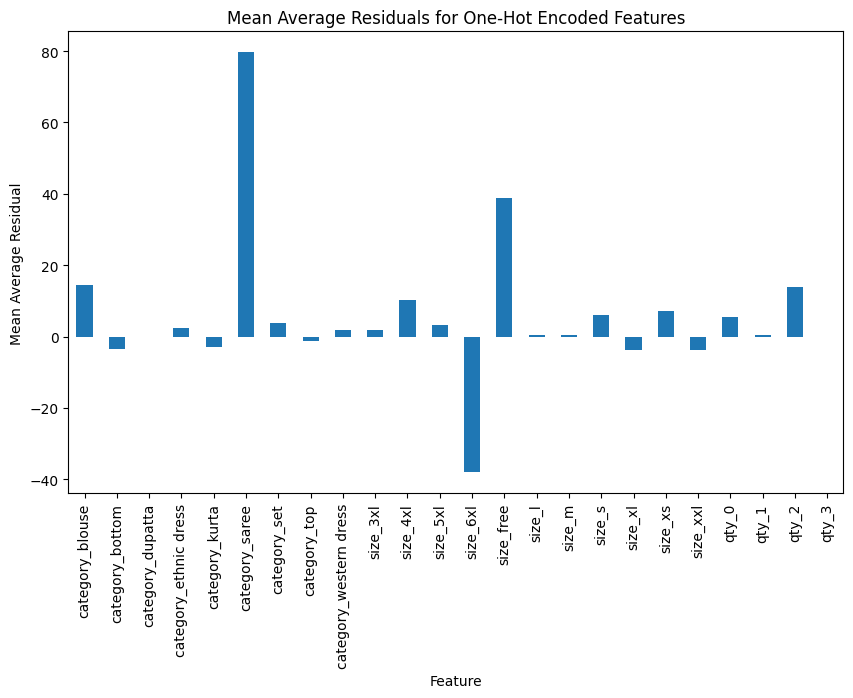

In [39]:
mean_residuals_per_feature.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Average Residuals for One-Hot Encoded Features')
plt.xlabel('Feature')
plt.ylabel('Mean Average Residual')
plt.xticks(rotation=90)  # Rotate feature names for better readability
plt.show()

In [41]:
#Iterate through a subset of X_test each containing a single one-hot encoded feature
from sklearn.metrics import r2_score
import numpy as np

# Initialize a dictionary to store R² scores for each one-hot encoded feature
feature_r2_scores = {}

for feature in X_test.columns:
    # Filter instances where the feature is "1"
    feature_mask = X_test[feature] == 1
    X_test_filtered = X_test[feature_mask]
    
    if not X_test_filtered.empty:
        # Ensure there are instances where feature is '1'
        y_test_filtered = y_test[feature_mask]
        
        # Make predictions for the filtered dataset
        predictions_filtered = model.predict(X_test_filtered).flatten()
        
        # Calculate R² score for the filtered dataset
        r2_score_filtered = r2_score(y_test_filtered, predictions_filtered)
        
        # Store the R² score
        feature_r2_scores[feature] = r2_score_filtered

# Sort the features by their R² score for better readability
sorted_feature_r2_scores = {feature: r2 for feature, r2 in sorted(feature_r2_scores.items(), key=lambda item: item[1], reverse=True)}

# Display the R² scores
for feature, r2 in sorted_feature_r2_scores.items():
    print(f"R-squared value for {feature}: {r2}")


2/2 [==============================] - 0s 2ms/step
R-squared value for size_free: 0.7533351288903648
R-squared value for qty_0: 0.509263041911127
R-squared value for size_xs: 0.45111771628947606
R-squared value for qty_2: 0.44475885691664696
R-squared value for size_m: 0.4399502971174799
R-squared value for size_xl: 0.4259162700816399
R-squared value for size_s: 0.42207399128252343
R-squared value for qty_1: 0.4206129147171308
R-squared value for size_3xl: 0.41831421832908566
R-squared value for size_l: 0.40744033881879305
R-squared value for size_xxl: 0.4035355812694754
R-squared value for category_kurta: 0.1682227842852424
R-squared value for category_blouse: 0.14841046483679843
R-squared value for category_bottom: 0.10359926040598244
R-squared value for category_top: 0.02529400525292036
R-squared value for size_5xl: 0.024994312977295263
R-squared value for category_ethnic dress: 0.006091625180460358
R-squared value for category_western dress: 0.005317170909247104
R-squared value for

In [42]:
from sklearn.metrics import r2_score

# Initialize a dictionary to store R² scores and sample counts for each one-hot encoded feature
feature_r2_scores_and_counts = {}

for feature in X_test.columns:
    # Filter instances where the feature is "1"
    feature_mask = X_test[feature] == 1
    X_test_filtered = X_test[feature_mask]
    
    if not X_test_filtered.empty:
        # Calculate the number of instances where the feature is "1"
        num_samples = X_test_filtered.shape[0]
        
        y_test_filtered = y_test[feature_mask]
        
        # Make predictions for the filtered dataset
        predictions_filtered = model.predict(X_test_filtered).flatten()
        
        # Calculate R² score for the filtered dataset
        r2_score_filtered = r2_score(y_test_filtered, predictions_filtered)
        
        # Store the R² score and the number of samples
        feature_r2_scores_and_counts[feature] = (r2_score_filtered, num_samples)

# Sort the features by their R² score for better readability
sorted_feature_r2_scores_and_counts = {feature: stats for feature, stats in sorted(feature_r2_scores_and_counts.items(), key=lambda item: item[1][0], reverse=True)}

# Display the R² scores and sample counts
for feature, (r2, count) in sorted_feature_r2_scores_and_counts.items():
    print(f"Feature: {feature}, R-squared value: {r2}, Number of samples: {count}")


2/2 [==============================] - 0s 2ms/step
Feature: size_free, R-squared value: 0.7533351288903648, Number of samples: 75
Feature: qty_0, R-squared value: 0.509263041911127, Number of samples: 962
Feature: size_xs, R-squared value: 0.45111771628947606, Number of samples: 1966
Feature: qty_2, R-squared value: 0.44475885691664696, Number of samples: 44
Feature: size_m, R-squared value: 0.4399502971174799, Number of samples: 4202
Feature: size_xl, R-squared value: 0.4259162700816399, Number of samples: 3806
Feature: size_s, R-squared value: 0.42207399128252343, Number of samples: 3094
Feature: qty_1, R-squared value: 0.4206129147171308, Number of samples: 22510
Feature: size_3xl, R-squared value: 0.41831421832908566, Number of samples: 2721
Feature: size_l, R-squared value: 0.40744033881879305, Number of samples: 4068
Feature: size_xxl, R-squared value: 0.4035355812694754, Number of samples: 3269
Feature: category_kurta, R-squared value: 0.1682227842852424, Number of samples: 9291

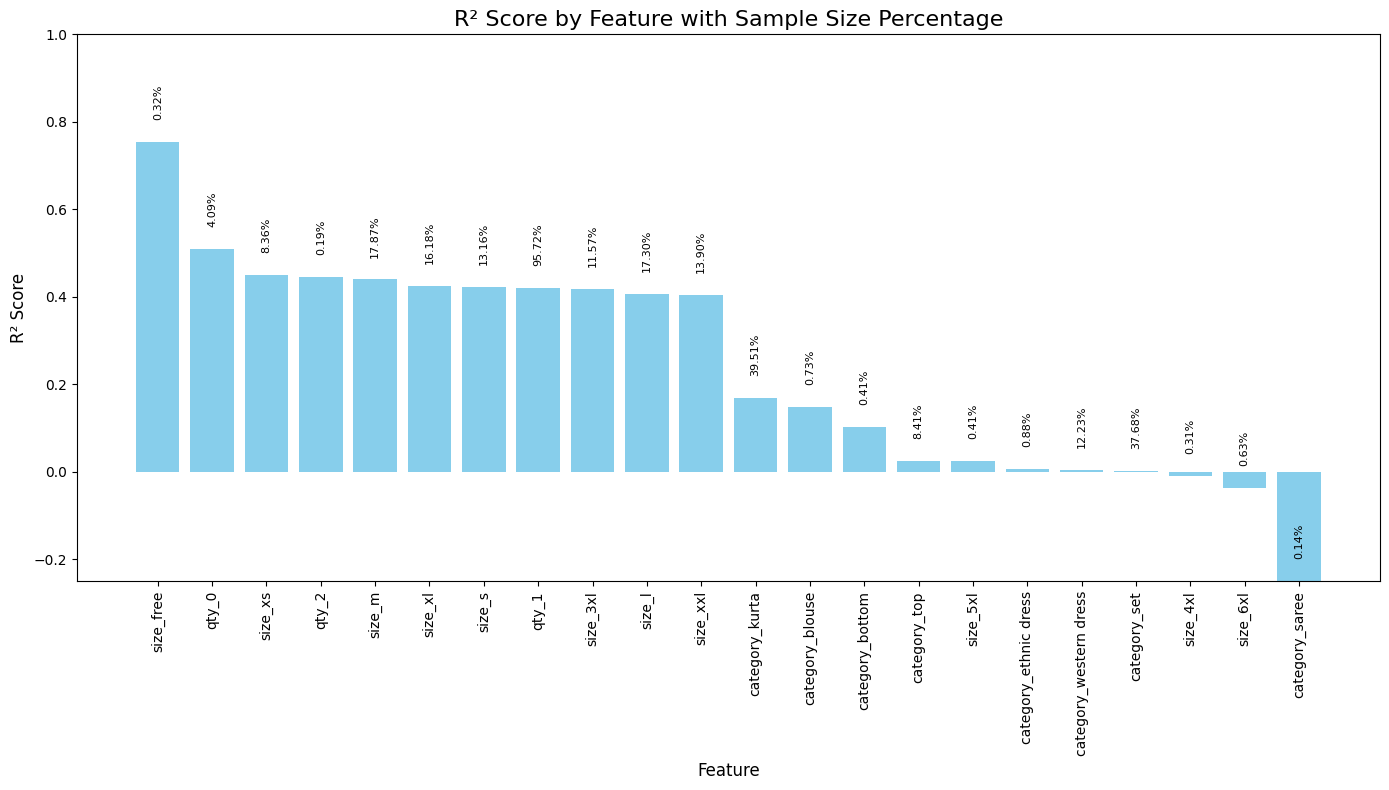

In [49]:
import matplotlib.pyplot as plt

# Assuming `sorted_feature_r2_scores_and_counts` contains your features, R2 scores, and sample counts as previously defined
# And assuming total test samples can be calculated from y_test or X_test
total_test_samples = len(y_test)

# Prepare data for plotting
features = list(sorted_feature_r2_scores_and_counts.keys())
r2_scores = [score for score, _ in sorted_feature_r2_scores_and_counts.values()]
sample_counts = [count for _, count in sorted_feature_r2_scores_and_counts.values()]
percentages = [(count / total_test_samples) * 100 for count in sample_counts]

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

# R2 Scores
ax.bar(features, r2_scores, color='skyblue', label='R² Score')
ax.set_xlabel('Feature', fontsize=12)
ax.set_ylabel('R² Score', fontsize=12)
ax.set_ylim([-0.25, 1])  # Set y-axis to range from -1 to 1 for R2 values
ax.tick_params(axis='x', rotation=90)
ax.set_title('R² Score by Feature with Sample Size Percentage', fontsize=16)

# Add percentage labels on top of each bar
for i, percentage in enumerate(percentages):
    ax.text(i, r2_scores[i] + 0.05, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=8, rotation=90)

plt.tight_layout()
plt.show()


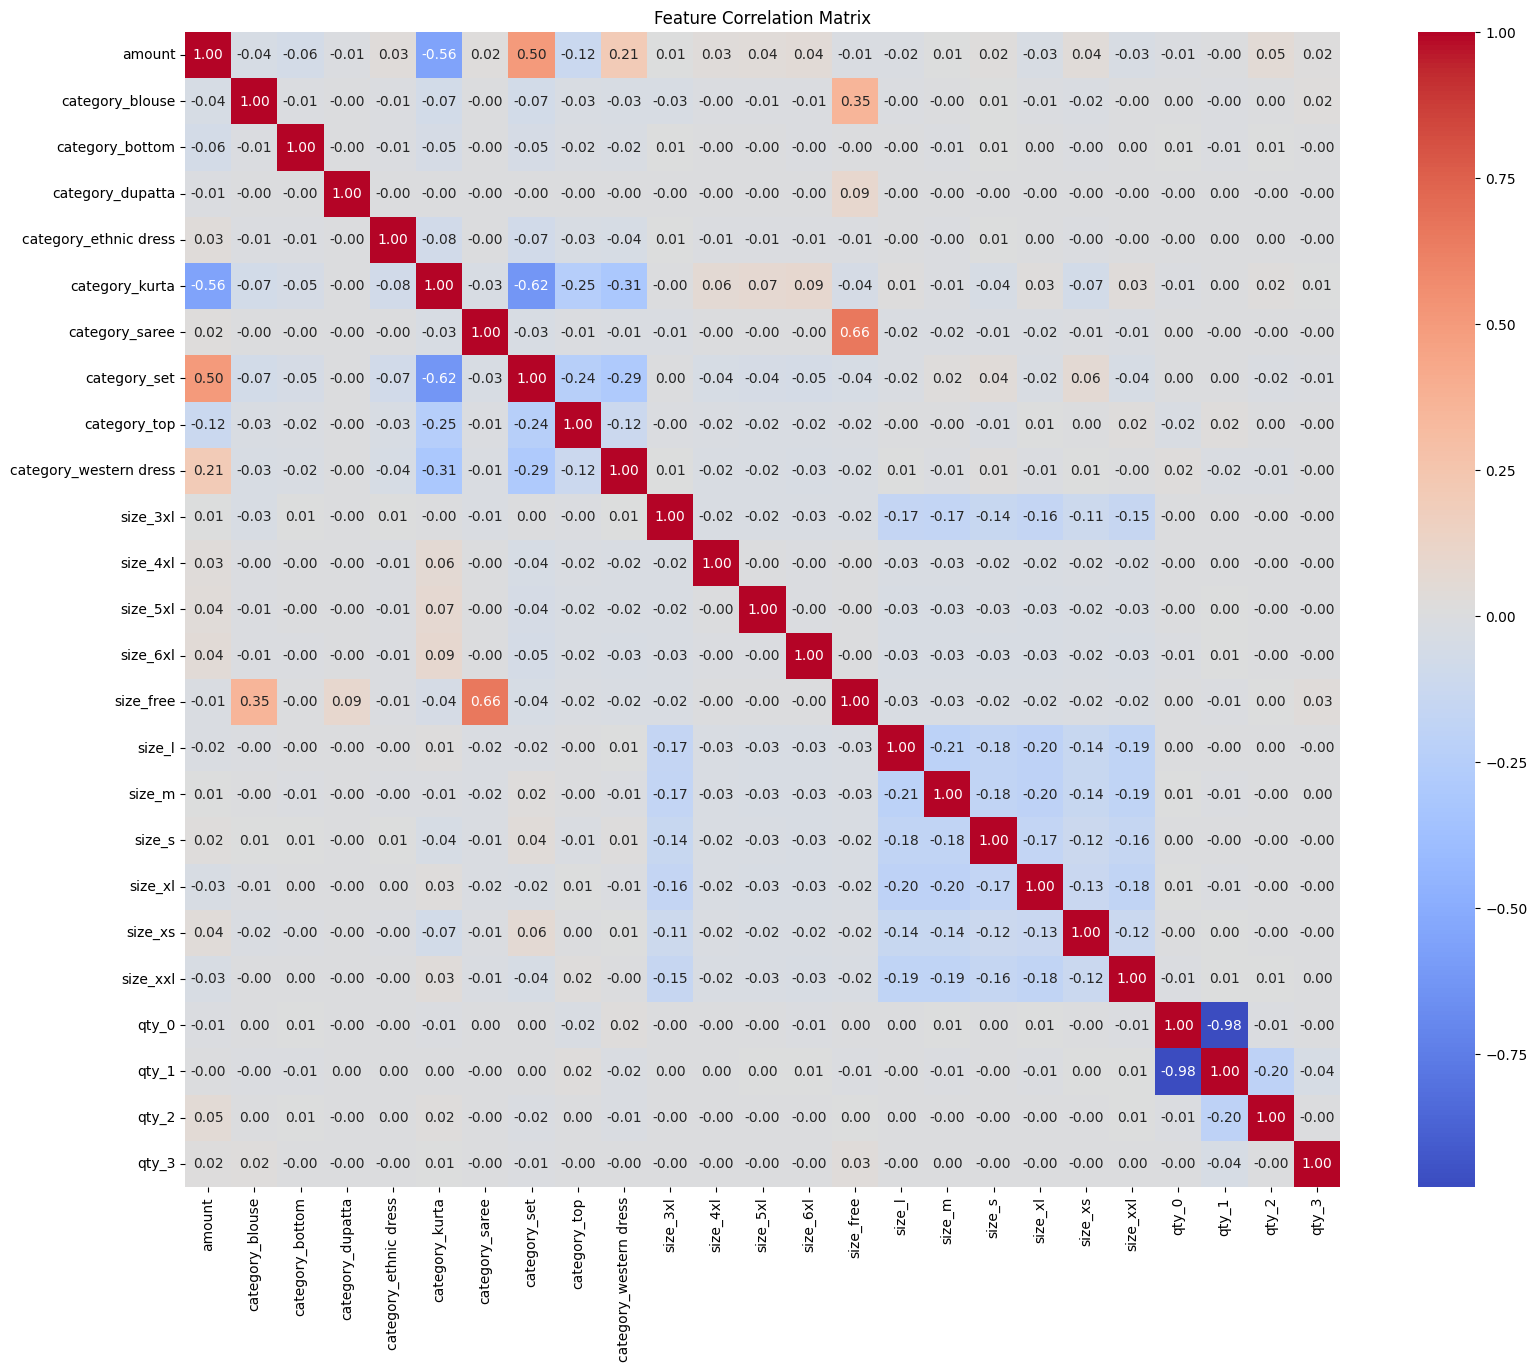

In [54]:
import seaborn as sns
corr_matrix = data_encoded.corr()

# Visualize the correlation matrix
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Feature Correlation Matrix')
plt.show()
